In [94]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.integrate import solve_ivp
import sys
import os

In [95]:
#parameters in cgs units
m = 9.1e-27
e = 5.e-10
qbym = -e/m #electrons
c = 3.e10

In [96]:
#fields same as in Fig. 1 of Qin+ paper https://ui.adsabs.harvard.edu/abs/2013PhPl...20h4503Q/abstract
def cal_E_par(x): 
    return 0.0

def cal_E_perp(x):
    return 0.01*np.array([x[0],x[1]])/(x[0]*x[0]+x[1]*x[1])**1.5

def cal_B(x):
    return (x[0]*x[0]+x[1]*x[1])**0.5

In [97]:
#initial conditions not explicitly stated in the paper; following arrived from a lot guessing; drift formulae are valid in asymptotic limit only
xi, yi, zi = 5., 0., 0.
E_perp = np.sqrt(np.sum(cal_E_perp([xi, yi, zi])**2)) #magnitude of Eperp
B = cal_B([xi, yi, zi])
w_c0 = e*B/(m*c)
v_EB_D = c*E_perp/B #magnitude of ExB drift
v_perp = np.abs(qbym*E_perp*0.25*2*np.pi/w_c0) #not the true value, just an estimate! particle accelerates for T_cyc/4
v_mugradB_D = 0.5*v_perp*v_perp/(w_c0*np.sqrt(xi*xi+yi*yi+zi*zi))
print(v_perp/w_c0, v_EB_D/c, v_mugradB_D/c, v_perp/c)
print(2.*np.pi/w_c0, 2.*np.pi*np.sqrt(xi*xi+yi*yi+zi*zi)/v_EB_D)
n_dump = 100000
vxi, vyi, vzi = 0., 0., 0.

0.41167430132640653 8e-05 5.173251842874999e-06 0.00012566370614359174
6.861238355440109e-07 1.308996938995747e-05


In [98]:
tend = 5000*2.0*np.pi/w_c0

In [99]:
def push_particles(xp, vp, acc_loc, dt): #xp, vp, acc_loc are vectors
    vp += dt*acc_loc #updated velocity
    xp += dt*vp #updated position
    return

def push_only_xp(xp, vp, dt): #update only xp for time dt, given vp 
    xp += dt*vp #updated position
    return

def push_only_vp(vp, acc_loc, dt): #update only vp for time dt, given acceleration on grid
    vp += dt*acc_loc
    return

In [100]:
#initialize coordinates
xp = np.array([xi, yi, zi])
vp = np.array([vxi, vyi, vzi])
E_perp = cal_E_perp(xp)
E_par = cal_E_par(xp)
B = cal_B(xp)
#first offset velocity by -dt/2 to use Leapfrog
acc_loc = qbym*np.array([E_perp[0]+vp[1]*B/c, E_perp[1]-vp[0]*B/c, E_par])
dt = 0.05*2*np.pi/w_c0 #1/20th of a cyclotron orbit
time = 0
data_t = []
data_t.append(np.append(xp,vp)) #appends to the list; list to hold 6 coordinates at each time
push_only_vp(vp, acc_loc, -0.5*dt) #offset velocity by -dt/2 to start Leap-frog

In [101]:
while (time < tend):
    dt = min(dt, tend-time)
    time += dt
    #push velocity
    #step 1 of Boris; apply E for dt/2
    acc_loc = qbym*np.array([E_perp[0], E_perp[1], E_par])
    vminus = 1.*vp
    push_only_vp(vminus, acc_loc, 0.5*dt)
    #step 2 of Boris; rotate at w_c
    w_c = qbym*B/c
    vplus_x = np.cos(w_c*dt)*vminus[0] + np.sin(w_c*dt)*vminus[1]
    vplus_y = -np.sin(w_c*dt)*vminus[0] + np.cos(w_c*dt)*vminus[1]
    vplus_z = vminus[2]
    #step 3 of Boris; apply E again for dt/2
    vp = np.array([vplus_x, vplus_y, vplus_z])
    push_only_vp(vp, acc_loc, 0.5*dt)
    #now do xp update
    push_only_xp(xp, vp, dt)
    #for output purposes again align x, v at same time; push velocity by dt/2
    v_out = 1.*vp
    E_perp = cal_E_perp(xp)
    E_par = cal_E_par(xp)
    B = cal_B(xp)
    acc_loc = qbym*np.array([E_perp[0]+vp[1]*B/c, E_perp[1]-vp[0]*B/c, E_par])
    push_only_vp(v_out, acc_loc, 0.5*dt) #offset velocity by dt/2 for output
    if (time != tend):
        data_t.append(np.append(xp, v_out))

In [102]:
dt = 0.05*2*np.pi/w_c0 #1/20th of a cyclotron orbit
print(np.shape(data_t))
t = np.arange(0, time, dt)

(100001, 6)
[0.00000000e+00 3.43061918e-08 6.86123836e-08 ... 3.43051626e-03
 3.43055057e-03 3.43058487e-03]
3.430619177720054e-08


(100001, 6)
(100000,)


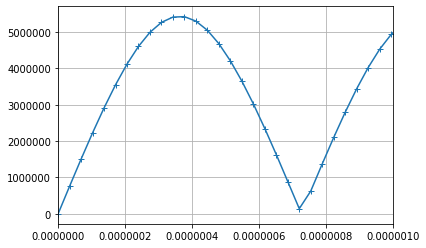

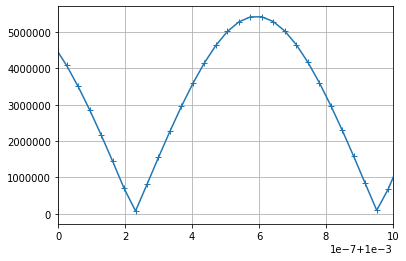

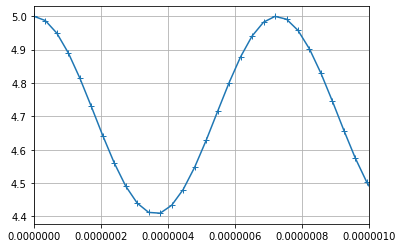

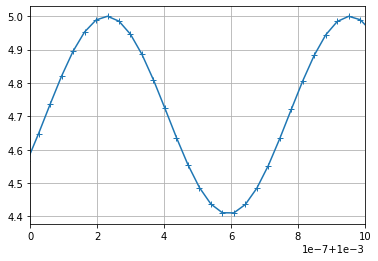

In [107]:
data_t = np.array(data_t)
print(np.shape(data_t))
print(np.shape(t))
plt.plot(t, np.sqrt(data_t[:-1,3]**2+data_t[:-1,4]**2),'-+')
plt.grid()
plt.xlim([0, 1e-6])
plt.figure()
plt.plot(t, np.sqrt(data_t[:-1,3]**2+data_t[:-1,4]**2),'-+')
plt.xlim([0.001, 0.001+1e-6])
plt.grid()
plt.figure()
plt.plot(t, np.sqrt(data_t[:-1,0]**2+data_t[:-1,1]**2),'-+')
plt.grid()
plt.xlim([0, 1e-6])
plt.figure()
plt.plot(t, np.sqrt(data_t[:-1,0]**2+data_t[:-1,1]**2),'-+')
plt.xlim([0.001, 0.001+1e-6])
plt.grid()

(-5.499464403951818, 5.499974495426277, -5.4948632142291265, 5.499621782411728)

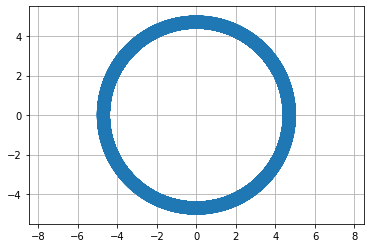

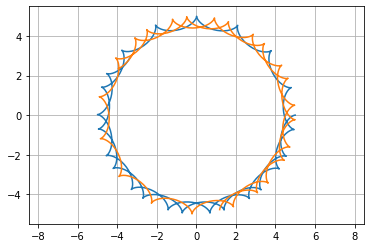

In [118]:
plt.plot(data_t[:,0], data_t[:,1])
#plt.axis('equal')
plt.grid()
plt.axis('equal')
plt.figure()
plt.plot(data_t[:500,0], data_t[:500,1])
plt.plot(data_t[-500:,0], data_t[-500:,1])
plt.grid()
plt.axis('equal')

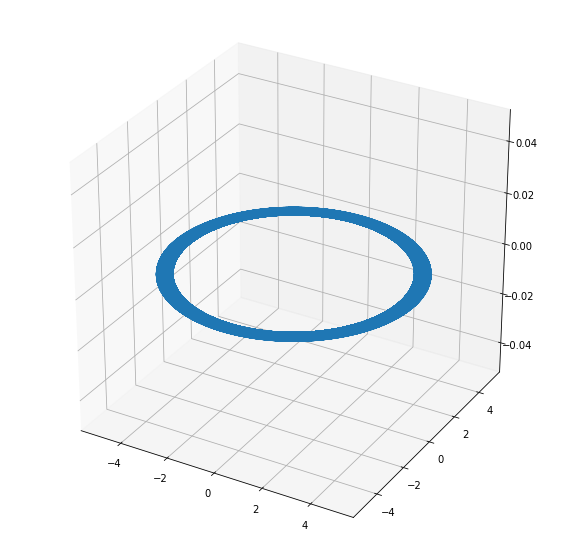

In [111]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
ax.plot3D(data_t[:-1,0], data_t[:-1,1], data_t[:-1,2])
plt.show()